In [1]:
import os, itertools
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from joblib import Parallel, delayed
from IPython import embed as shell
import h5py

from tools_mcginley import utils
import analyses_tools

In [2]:
cur_dir = os.getcwd()
print('The current working directory is', cur_dir)

The current working directory is /home/jovyan/hddm


In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='ticks', font='Arial', font_scale=1, rc={
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': 0.25,
    'xtick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.pad' : 2.0,
    'ytick.minor.pad' : 2.0,
    'xtick.major.pad' : 2.0,
    'xtick.minor.pad' : 2.0,
    'axes.labelpad' : 4.0,
    'axes.titlepad' : 6.0,
    } )
sns.plotting_context()

{'font.size': 12.0,
 'axes.labelsize': 7.0,
 'axes.titlesize': 7.0,
 'xtick.labelsize': 6.0,
 'ytick.labelsize': 6.0,
 'legend.fontsize': 6.0,
 'axes.linewidth': 0.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.25,
 'ytick.major.width': 0.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 12.0}

In [4]:
def plot_hazard():
    
    # hazard rate:
    p = np.array([0, 0.228, 0.204, 0.18, 0.157, 0.133, 0.109])
    h = p.copy()
    for i in range(len(p)):
        h[i] = h[i] / sum(h[i:])
    x = np.arange(len(h))
    fig = plt.figure(figsize=(3,1.5))
    ax = fig.add_subplot(121)
    plt.scatter(x,p)
    plt.plot(x,p)
    plt.xlabel('TORC #')
    plt.ylabel('P(signal)')    
    ax = fig.add_subplot(122)
    plt.scatter(x,h)
    plt.plot(x,h)
    plt.xlabel('TORC #')
    plt.ylabel('Hazard rate')
    sns.despine(offset=3, trim=True)
    plt.tight_layout()
    return fig

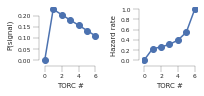

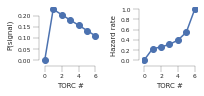

In [16]:
plot_hazard()

In [6]:
def plot_pupil_hazard(df):
    df['last_interval'] = df['interval']
    acc = np.array(df.loc[df['stimulus']==1,:].groupby(['subject', 'last_interval']).mean().groupby('last_interval').mean()['correct'])
    acc_sem = np.array(df.loc[df['stimulus']==1,['subject', 'last_interval', 'correct']].groupby(['subject', 'last_interval']).mean().groupby('last_interval').sem())
    pupil = np.array(df.groupby(['subject', 'last_interval']).mean().groupby('last_interval').mean()['pupil_stim_1s'])
    pupil_sem = np.array(df.loc[:,['subject', 'last_interval', 'pupil_stim_1s']].groupby(['subject', 'last_interval']).mean().groupby('last_interval').sem())

    aovrm = AnovaRM(df.groupby(['subj_idx', 'interval']).mean().reset_index(), 'pupil_stim_1s', 'subj_idx', within=['interval'], aggregate_func='mean')
    res = aovrm.fit()
    print(res)

    x = np.arange(2,8)

    fig = plt.figure(figsize=(3,1.5))
    ax = fig.add_subplot(121)
    plt.errorbar(x, acc, yerr=acc_sem)
    plt.xlabel('TORC #')
    plt.ylabel('Accuracy')
    ax = fig.add_subplot(122)
    plt.errorbar(x, pupil, yerr=pupil_sem)
    plt.xlabel('TORC #')
    plt.ylabel('Pupil response')
    plt.ylim(4,8.5)
    sns.despine(offset=3, trim=True)
    plt.tight_layout()
    return fig

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
interval  2.1768 5.0000 20.0000 0.0977



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


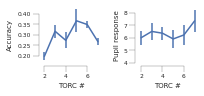

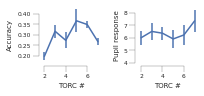

In [17]:
plot_pupil_hazard(df)

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - ddm

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [14]:
def baseline_correlation(df):

    fig = plt.figure(figsize=(1.5*10, 1.5*6))
    plt_nr = 1
    rs = np.zeros(len(df['subject'].unique()))
    ps = np.zeros(len(df['subject'].unique()))
    for s, d in df.groupby(['subj_idx']):
        ax = fig.add_subplot(6,10,plt_nr)        
        sns.regplot(x='pupil_0', y='pupil_resp_1s', scatter=True, fit_reg=True, data=d, ax=ax, scatter_kws={'alpha':0.1, 's':2, 'rasterized':True})
        #plt.xlim(df['pupil_0'].quantile(0.05), df['pupil_0'].quantile(0.95))
        #plt.ylim(df['pupil_resp_1s'].quantile(0.05), df['pupil_resp_1s'].quantile(0.95))
        r,p = sp.stats.pearsonr(d['pupil_0'], d['pupil_resp_1s'])
        rs[plt_nr-1] = r
        ps[plt_nr-1] = p
        plt.title('r = {}, p = {}'.format(round(np.mean(r),3), round(p, 3)))
        plt_nr += 1
    ax = fig.add_subplot(6,10,plt_nr) 
    sns.swarmplot(x=None, y=rs[ps<=0.05], color='g')
    sns.swarmplot(x=None, y=rs[ps>0.05])
    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    fig2 = plt.figure(figsize=(2,2))
    ax = fig2.add_subplot(111)   
    sns.regplot(x='pupil_0', y='pupil_resp_1s', units='subj_idx', scatter=True, fit_reg=False, x_bins=20, data=df, ax=ax)
    return fig

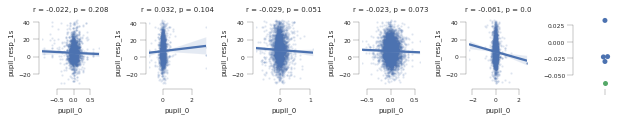

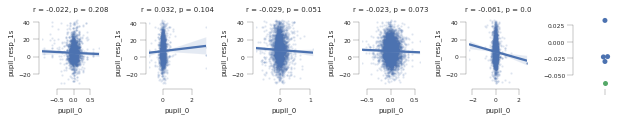

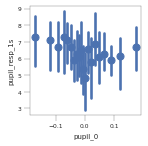

In [15]:
baseline_correlation(df)

In [10]:
# variables:
project_dir = '/home/jovyan/hddm'
exp_names = [
    'gonogo_audio_mouse',
    'gonogo_audio_human',
    'yesno_audio',
    'bias_manipulation_30', 
    'bias_manipulation_70',
    'image_recognition',
    ]
rt_cutoffs = [
    (0.28, 1.5),
    (0.55, 1.0),
    (0.55, 2.5),
    (0.55, 2.5), 
    (0.55, 2.5),
    (0.55, 7.5),
    ]

pupil_cutoffs = [
    [(0.04,0.23), (0.04,0.23),],
    [(0.23,0.50), (0.23,0.50),],
    [(0.23,0.5), (-0.55, -0.05)],
    [(0.23,0.5), (-0.55, -0.05)],
    [(0.23,0.5), (-0.55, -0.05)],
    [(0.23,0.5), (-0.55, -0.05)],
    ]

nrs_bins = [
    5,
    5,
    5,
    3,
    3,
    2,
    ]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


AttributeError: module 'mne' has no attribute 'stats'

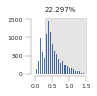

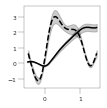

In [11]:
# for analyse_exp in [0,1,2,3,4,5]:
for analyse_exp in [0]:

    exp_name, rt_cutoff, pupil_cutoff, nr_bin = exp_names[analyse_exp], rt_cutoffs[analyse_exp], pupil_cutoffs[analyse_exp], nrs_bins[analyse_exp]

    # load data:
    df = pd.read_csv(os.path.join(project_dir, 'data', 'df_meta_{}.hdf'.format(exp_name)))
    epoch_p_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_stim_{}.hdf'.format(exp_name)))
    epoch_p_s_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_s_stim_{}.hdf'.format(exp_name)))
    epoch_b_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_b_stim_{}.hdf'.format(exp_name)))
    if 'gonogo' in exp_name:
        epoch_p_resp = epoch_p_stim.copy()
        epoch_p_s_resp = epoch_p_s_stim.copy()
        epoch_b_resp = epoch_b_stim.copy()
    else:
        epoch_p_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_resp_{}.hdf'.format(exp_name)))
        epoch_p_s_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_s_resp_{}.hdf'.format(exp_name)))
        epoch_b_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_b_resp_{}.hdf'.format(exp_name)))

    # variables:
    df['hit'] = ((df['stimulus']==1)&(df['response']==1)).astype(int)
    df['fa'] = ((df['stimulus']==0)&(df['response']==1)).astype(int)
    df['miss'] = ((df['stimulus']==1)&(df['response']==0)).astype(int)
    df['cr'] = ((df['stimulus']==0)&(df['response']==0)).astype(int)
    df['correct'] = (df['stimulus']==df['response']).astype(int)

    # timepoints:
    x_stim = np.array(epoch_p_stim.columns, dtype=float)
    x_s_stim = np.array(epoch_p_s_stim.columns, dtype=float)
    x_resp = np.array(epoch_p_resp.columns, dtype=float)
    x_s_resp = np.array(epoch_p_s_resp.columns, dtype=float)

    # baseline:
    baselines = np.atleast_2d(epoch_p_stim.loc[:,(x_stim>-1)&(x_stim<0)].mean(axis=1)).T
    epoch_p_stim = epoch_p_stim - baselines
    epoch_p_resp = epoch_p_resp - baselines

    # rt distribution:
    fig = analyses_tools.histogram(df.loc[df['rt']<10], rt_cutoff)
    fig.savefig(os.path.join(project_dir, 'figs', 'rt_distribution_{}.pdf'.format(exp_name)))

    # add blinks:
    df['blink'] = np.array(epoch_b_resp.loc[:,(x_resp>=pupil_cutoff[1][0])&(x_resp<=pupil_cutoff[1][1])].sum(axis=1) > 0.5)
    
    # add pupil values:
    df['pupil_0'] = np.array(epoch_p_stim.loc[:,(x_s_stim>-0.5)&(x_s_stim<0)].mean(axis=1))
    df['pupil_stim_1s'] = np.array(epoch_p_s_stim.loc[:,(x_s_stim>pupil_cutoff[0][0])&(x_s_stim<pupil_cutoff[0][1])].quantile(0.95, axis=1))
    df['pupil_resp_1s'] = np.array(epoch_p_s_resp.loc[:,(x_s_resp>pupil_cutoff[1][0])&(x_s_resp<pupil_cutoff[1][1])].quantile(0.95, axis=1))

    # fix baselines for go-nogo:
    if 'gonogo' in exp_name:
        df.loc[df['interval']!=1, 'pupil_0'] = np.NaN
        df.loc[:,'pupil_0'] = df.loc[:,'pupil_0'].fillna(axis=0, method='ffill')

    # omissions step 1:
    omissions = (
        np.zeros(df.shape[0], dtype=bool)
        + np.array(df['response']==-1)
        + np.array(df['blink']==1)
        )
    if 'gonogo' in exp_name:
        omissions = omissions + np.array(df['interval']==1)
        pass
    elif exp_name == 'image_recognition':
        omissions = omissions + np.isnan(df['emotional'])
    df = df.loc[~omissions,:].reset_index(drop=True)
    epoch_p_stim = epoch_p_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_resp = epoch_p_resp.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_stim = epoch_p_s_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_resp = epoch_p_s_resp.loc[~omissions,:].reset_index(drop=True)

    # omissions step 2:
    omissions = np.array(df['rt'] < rt_cutoff[0]) + np.array(df['rt'] > rt_cutoff[1]) + np.array(np.isnan(df['pupil_resp_1s'])) + np.array(analyses_tools.is_outlier(df['pupil_resp_1s']))
    df = df.loc[~omissions,:].reset_index(drop=True)
    epoch_p_stim = epoch_p_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_resp = epoch_p_resp.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_stim = epoch_p_s_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_resp = epoch_p_s_resp.loc[~omissions,:].reset_index(drop=True)

    # # correct phasic pupil measures:
    # for (subj, ses), d in df.groupby(['subject', 'session']):
    #     ind = (df['subject']==subj)&(df['session']==ses)&~np.isnan(df['pupil_1'])
    #     df.loc[ind, 'pupil_1'] = myfuncs.lin_regress_resid(df.loc[ind, 'pupil_1'], [df.loc[ind, 'rt'],]) + df.loc[ind, 'pupil_1'].mean()
    #     # df.loc[ind, 'pupil_1s_stim'] = myfuncs.lin_regress_resid(df.loc[ind, 'pupil_1s_stim'], [df.loc[ind, 'pupil_0']]) + df.loc[ind, 'pupil_1s_stim'].mean()
    #     # df.loc[ind, 'pupil_1s_resp'] = myfuncs.lin_regress_resid(df.loc[ind, 'pupil_1s_resp'], [df.loc[ind, 'pupil_0']]) + df.loc[ind, 'pupil_1s_resp'].mean()

    # add more variables:
    subjects = df['subject'].unique()
    df['subj_idx'] = np.concatenate(np.array([np.repeat(i, sum(df['subject'] == subjects[i])) for i in range(len(subjects))]))

    # save for ddm fitting:
    df.to_csv(os.path.join(project_dir, 'data', 'ddm', '{}.csv'.format(exp_name)))

    # pupil responses:
    if 'mouse' in exp_name:
        stat_by = ['subject', 'run']
    else:
        stat_by = ['subject']
    if 'gonogo' in exp_name:
        bin_by = 'pupil_stim_1s'
    else:
        bin_by = 'pupil_resp_1s'
    fig = analyses_tools.plot_responses(df, epoch_p_stim, epoch_p_s_stim, span=pupil_cutoff[0], stat_by=stat_by, bin_by=bin_by)
    fig.savefig(os.path.join(project_dir, 'figs', 'responses_stim_{}.pdf'.format(exp_name)))
    fig = analyses_tools.plot_responses(df, epoch_p_resp, epoch_p_s_resp, span=pupil_cutoff[1], stat_by=stat_by, bin_by=bin_by)
    fig.savefig(os.path.join(project_dir, 'figs', 'responses_resp_{}.pdf'.format(exp_name)))
    
    # baseline phasic correlations:    
    fig = baseline_correlation(df)
    fig.savefig(os.path.join(project_dir, 'figs', 'baseline_correlations_{}.pdf'.format(exp_name)))

    # # mini block analyses:
    # if 'gonogo' in exp_name:
    #     fig = plot_hazard()
    #     fig.savefig(os.path.join(project_dir, 'figs', 'hazard.pdf'))
    #     fig = plot_pupil_hazard(df)
    #     fig.savefig(os.path.join(project_dir, 'figs', 'hazard_behavior_{}.pdf'.format(exp_name)))

    # sdt bars:
    if 'gonogo' in exp_name:
        df = analyses_tools.prepare_df(df)
    
    # for bin_measure in ['pupil_resp_1s', 'pupil_stim_1s', 'pupil_0']:
    for bin_measure in ['pupil_0']:
        
        if 'gonogo' in exp_name:
            df['bin'] = df.groupby(['subj_idx', 'level', 'stimulus'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'level', 'bin'])
            params = params.groupby(['subj_idx', 'bin']).mean().reset_index()
            params['c2'] = np.array(df.groupby(['subj_idx', 'bin']).apply(analyses_tools.composite_bias))
            params = params.loc[:,params.columns!='level'].melt(id_vars=['subj_idx', 'bin'])
        elif exp_name == 'image_recognition':
            df['bin'] = df.groupby(['subj_idx', 'emotional'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'bin']).melt(id_vars=['subj_idx', 'bin'])
        else:
            df['bin'] = df.groupby(['subj_idx'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'bin']).melt(id_vars=['subj_idx', 'bin'])
        
        # # add pupil response:
        # params[bin_measure] = np.NaN
        # for (v, b), params_cut in params.groupby(['variable', 'bin']):
        #     if len(params_cut.index) == len(params['subj_idx'].unique()):
        #         params.loc[params_cut.index, bin_measure] = np.array(df.groupby(['subj_idx', 'bin']).mean().reset_index().query('bin=={}'.format(b))[bin_measure])

        # SDT plots:
        fig = analyses_tools.mixed_linear_modeling(params, 'bin')
        # fig = mixed_linear_modeling(params, bin_measure)
        fig.savefig(os.path.join(project_dir, 'figs', 'bars_sdt_{}_{}.pdf'.format(exp_name, bin_measure)))

        if 'gonogo' in exp_name:
            # df['bin'] = df.groupby(['subj_idx', 'level', 'stimulus'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'level', 'bin']).melt(id_vars=['subj_idx', 'level', 'bin'])

            fig = analyses_tools.mixed_linear_modeling(params.groupby(['subj_idx', 'variable', 'level']).mean().reset_index(), 'level')
            # fig = analyses_tools.mixed_linear_modeling(params, bin_measure)
            fig.savefig(os.path.join(project_dir, 'figs', 'bars_sdt_level_{}_{}.pdf'.format(exp_name, bin_measure)))

            fig = analyses_tools.mixed_linear_modeling(params, 'bin')
            # fig = analyses_tools.mixed_linear_modeling(params, bin_measure)
            fig.savefig(os.path.join(project_dir, 'figs', 'bars_sdt_bin_level_{}_{}.pdf'.format(exp_name, bin_measure)))


<bound method Figure.savefig of <Figure size 1080x648 with 6 Axes>>

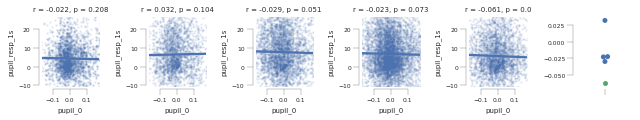

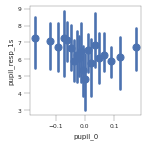

In [12]:
fig = baseline_correlation(df)
fig.savefig